# Evaluate data preparation methodology

## Notes
* Set max dist around 1500 km which is between 4 and 5 degrees lat/lon
* Using 30 bins with max dist of 1500 km gives a bin width of about 50 km (or approximately 0.5 degrees)
* "A good distance between lags should be no smaller than the shortest distance between data points, and should be close to the average spacing of samples. The ideal lag spacing includes roughly the same number of pairs in each lag, and at least 30 pairs for each lag." (https://vsp.pnnl.gov/help/vsample/Kriging_Variogram.htm)
* "Tolerance regions should be as small as possible to retain spatial resolution, yet large enough so that the estimator is stable." (Cressie, 1993) i.e., at least 30 pairs per bin.

## Findings
* Even with a bin width of 15 km (100 bins), emp. semivars. are still quite smooth. However, fewer than 30 pairs in some bins. Safely use larger bin width.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import fields
import cov_model
import plot

%matplotlib inline

In [3]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

## Overview analysis

In [4]:
# TBH we could just compute the mean upon preprocessing and simplify some of this... but it might be useful code to have in the future
def full_preprocess(ds):
    return xr.concat([fields.preprocess_ds(ds, t) for t in ds.time], dim="time")

def combined_climatologies(da1, da2):
    df1 = da1.mean(dim=["lon", "lat"]).to_dataframe().reset_index()
    df2 = da2.mean(dim=["lon", "lat"]).to_dataframe().reset_index()
    return pd.merge(df1, df2, on=["time"], how="outer")

In [5]:
# Construct preprocessed xco2 and sif datasets
ds_xco2_prep = full_preprocess(ds_xco2)
ds_sif_prep = full_preprocess(ds_sif)

# Monthly climatologies of residuals
df_monthly = combined_climatologies(ds_xco2_prep.xco2, ds_sif_prep.sif)

/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


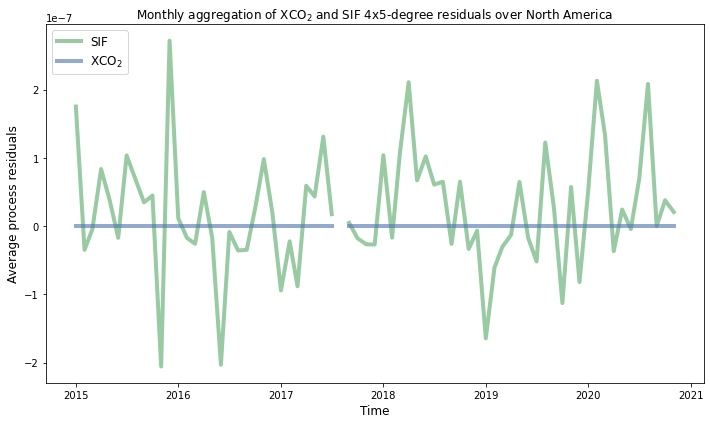

In [6]:
# Plot regional monthly climatology
"""
NOTE: 
- the timeseries for XCO2 appears completely flat, but is not so at order of mag. e-16 (machine precision)
- in any case, this type of plot won't give us much info about the temporal relationship between XCO2 and SIF
"""
title = "Monthly aggregation of XCO$_2$ and SIF 4x5-degree residuals over North America"
fname = "climatologies_conus_residuals_sd_nofilter"
plot.resid_climatology(df_monthly, title, fname)

## Targeted analysis

In [7]:
# Analysis variables
month = 8
timedelta = -1
n_bins = 30
max_dist = 1500
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")

params_guess = [1.0, 1.5, 700, 0.0, 1.5, 700, -0.4, 1.0, 1.5, 700, 0.0]


In [8]:
def variography_analysis(timestamp):

    k1 = cov_model.Matern()
    k2 = cov_model.Matern()

    mf = fields.MultiField(
        ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist
    )
    if mf.field_1.values.size == 0:
        return None

    model = cov_model.BivariateMatern(mf, k1, k2)
    vario_res, covario_res, params_fit = model.empirical_variograms(
        params_guess, n_bins=n_bins, max_dist=max_dist
    )

    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[9] - lags[8]

    # Plot maps
    # fname = f"4x5degree_residuals_{timestamp}_sd"
    plot.plot_fields(mf, coord_avg=True)

    # Q-Q plots
    plot.qq_plots(mf)

    # Plot variograms
    # semi_name = f"semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag"
    plot.plot_variograms(vario_res, timestamp, timedelta, params=params_fit)
    # cov_name = f"covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag"
    plot.plot_variograms(
        covario_res,
        timestamp,
        timedelta,
        params=params_fit,
        type_lab="Covariogram",
        scale_lab="Covariance",
    )


/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/joshjacobson/Projects/sif-data-fusion/conda-env/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/joshjacobson/Projects/sif-data-fusion/conda-e

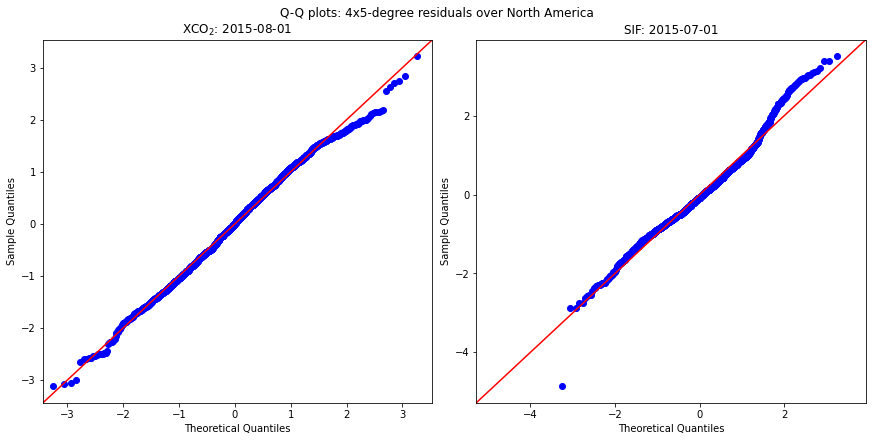

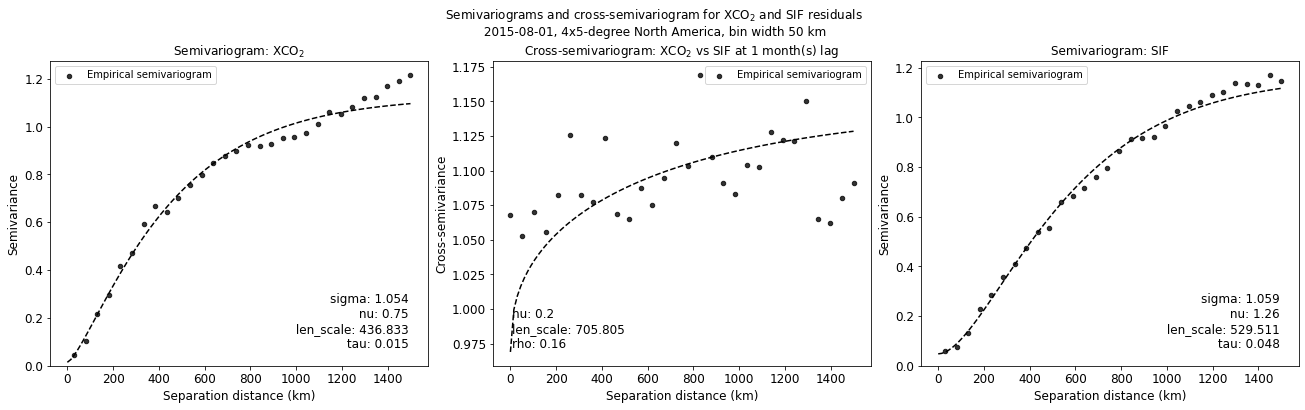

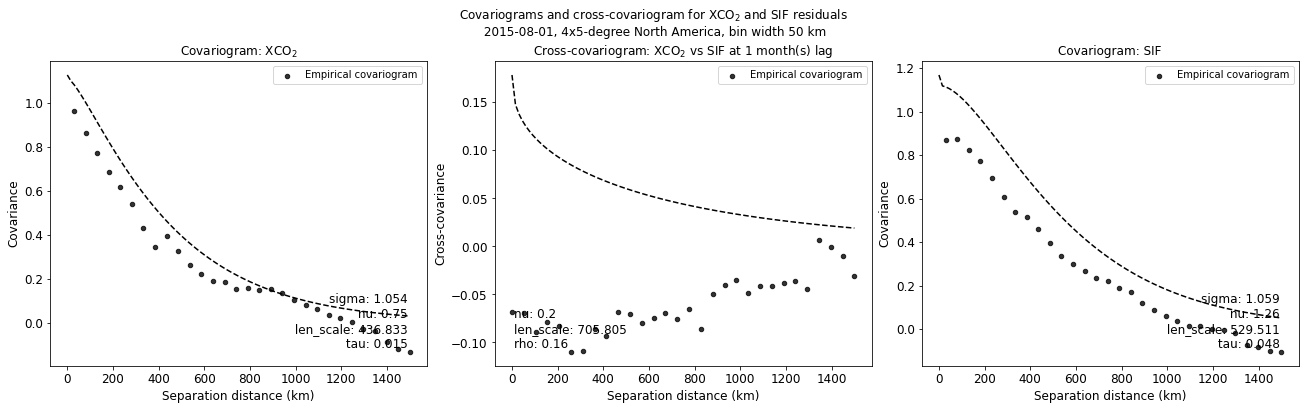

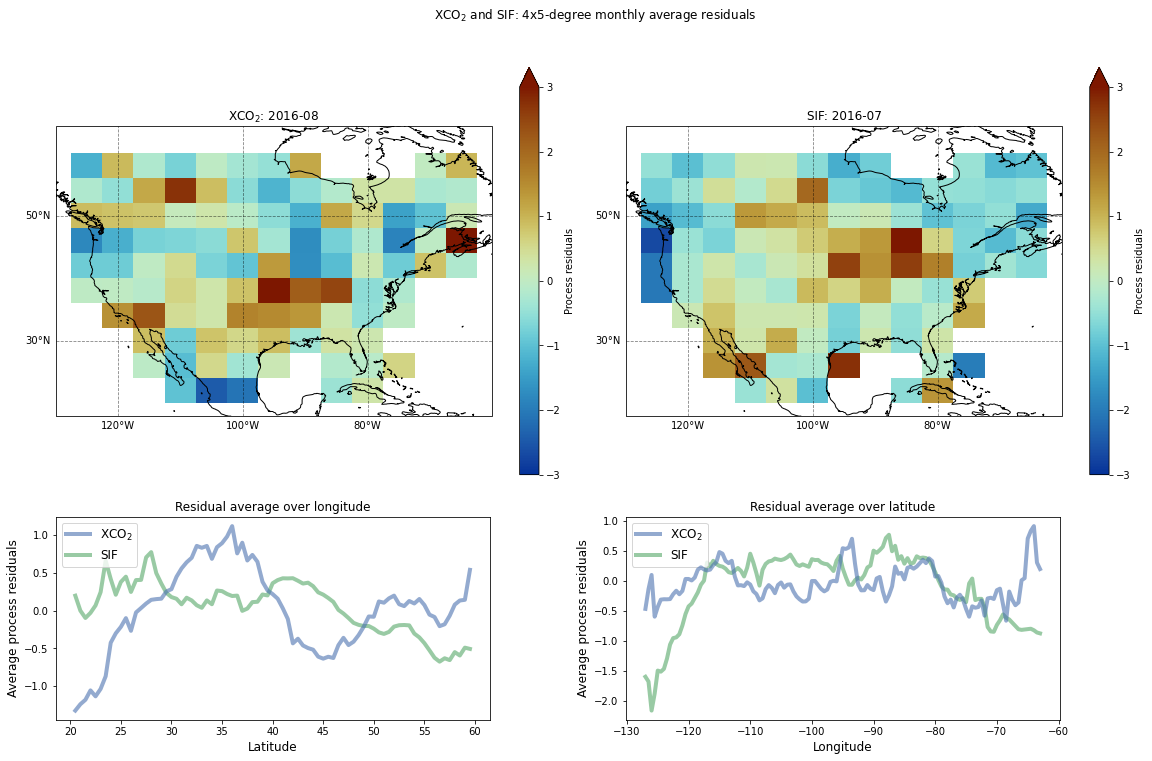

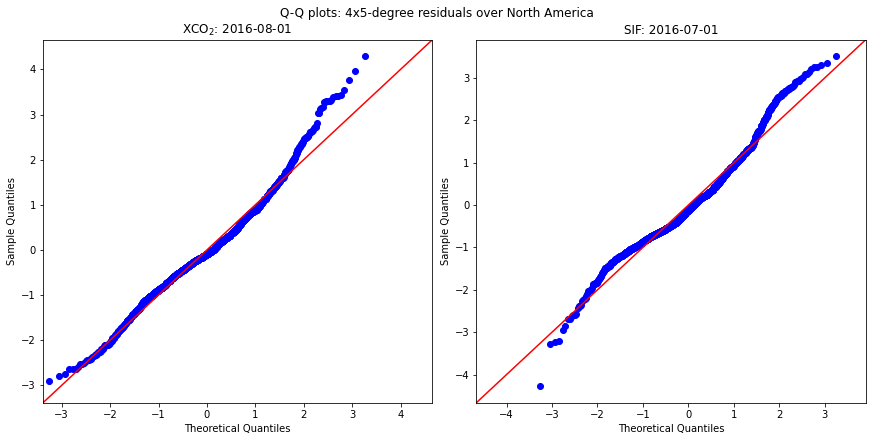

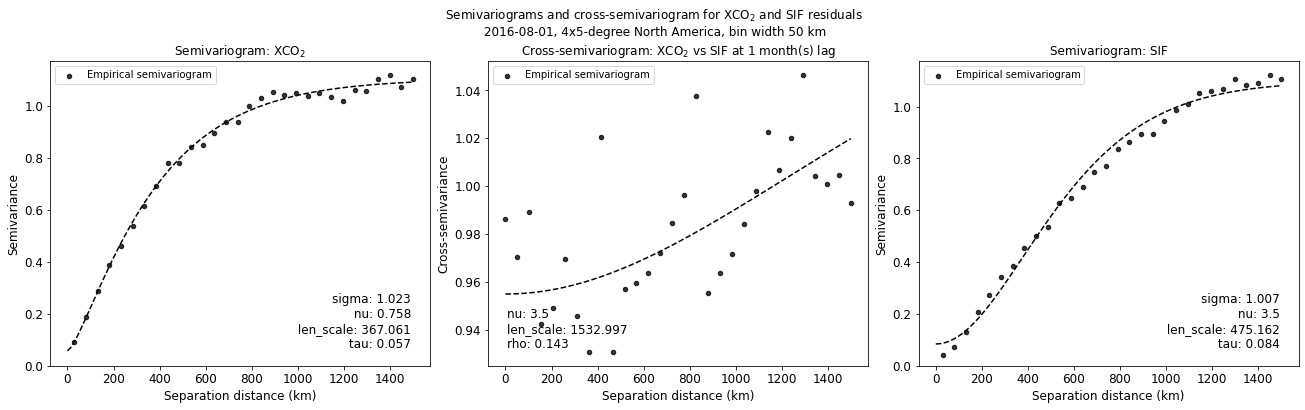

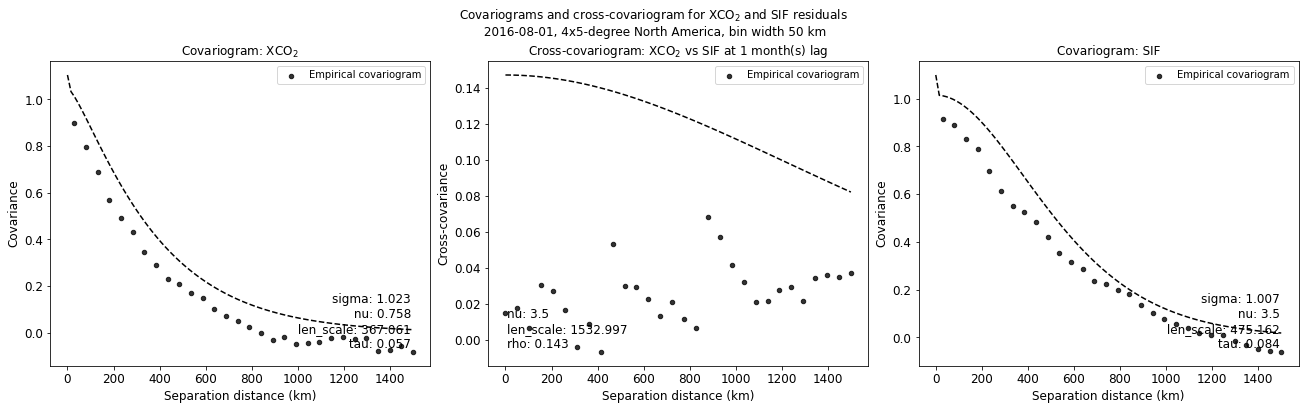

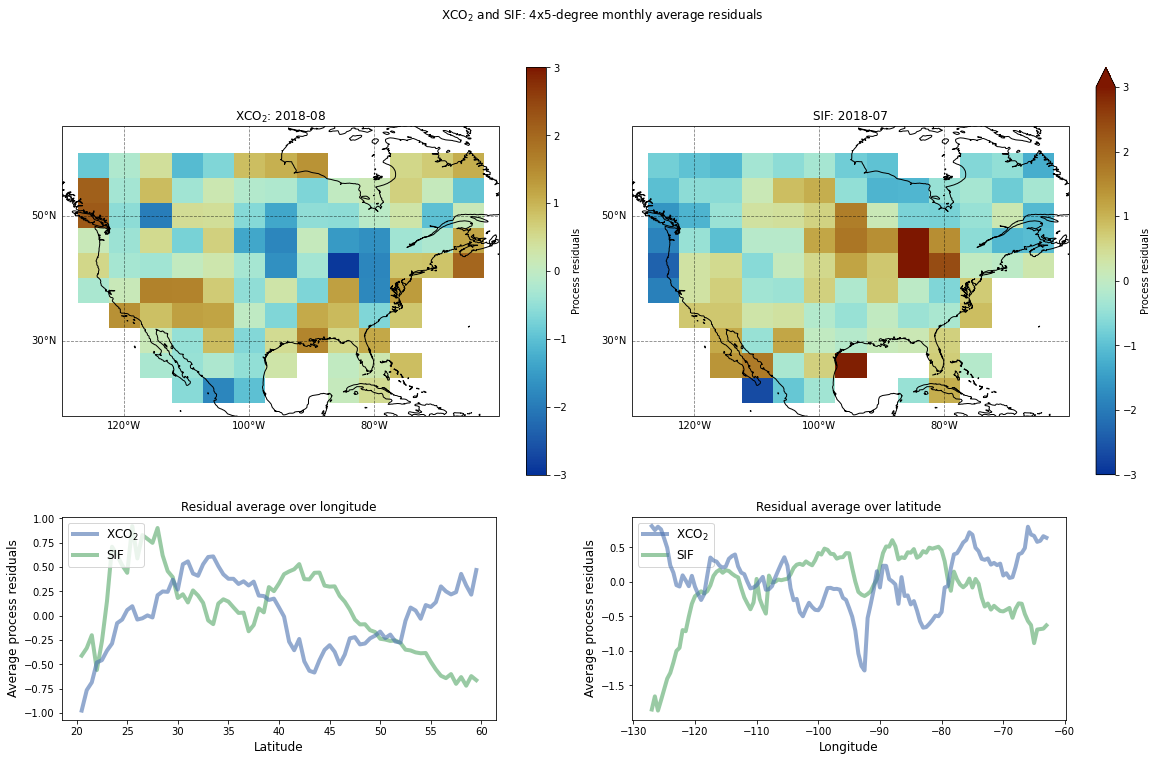

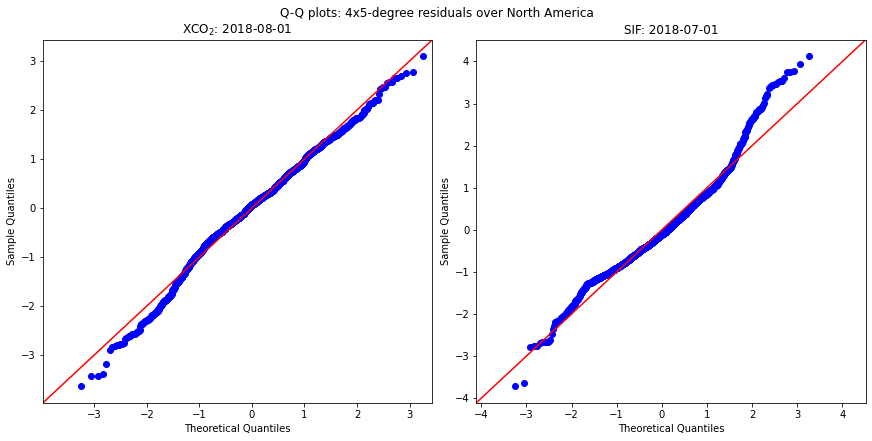

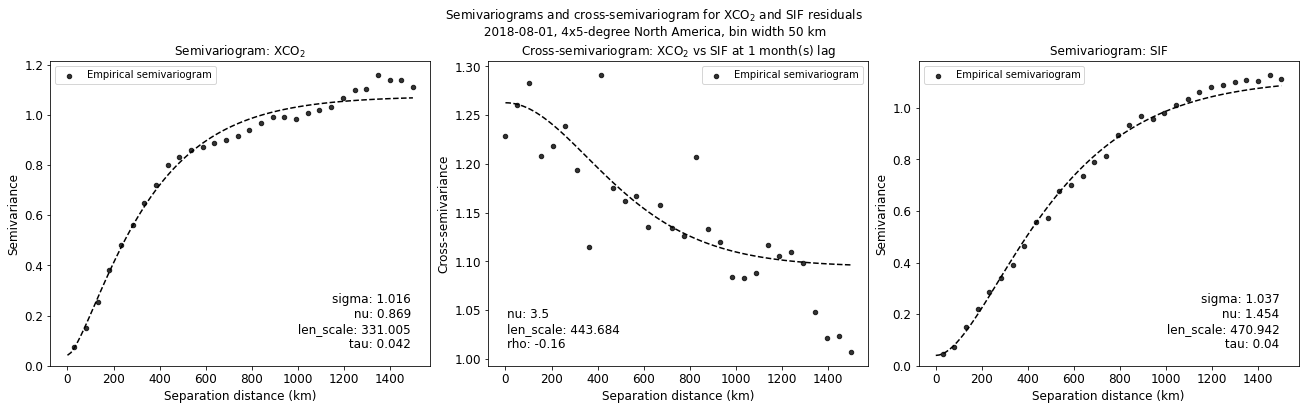

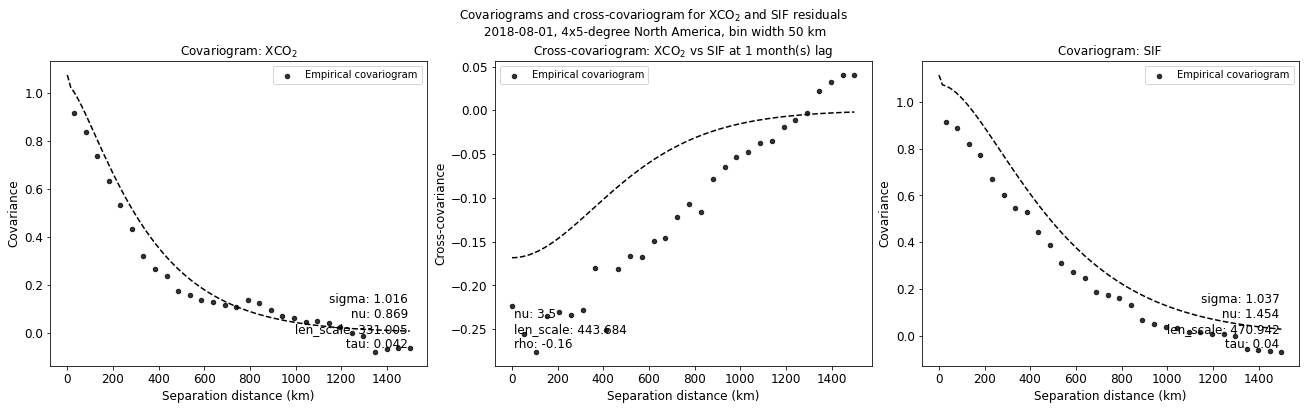

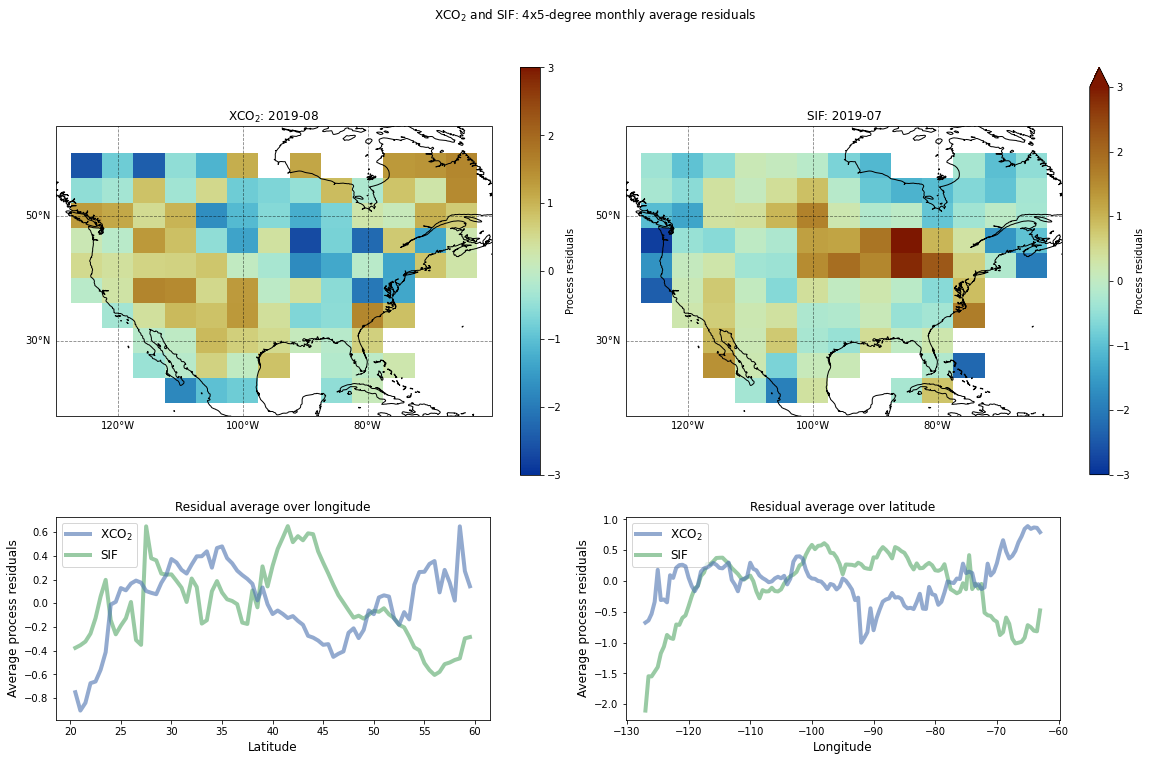

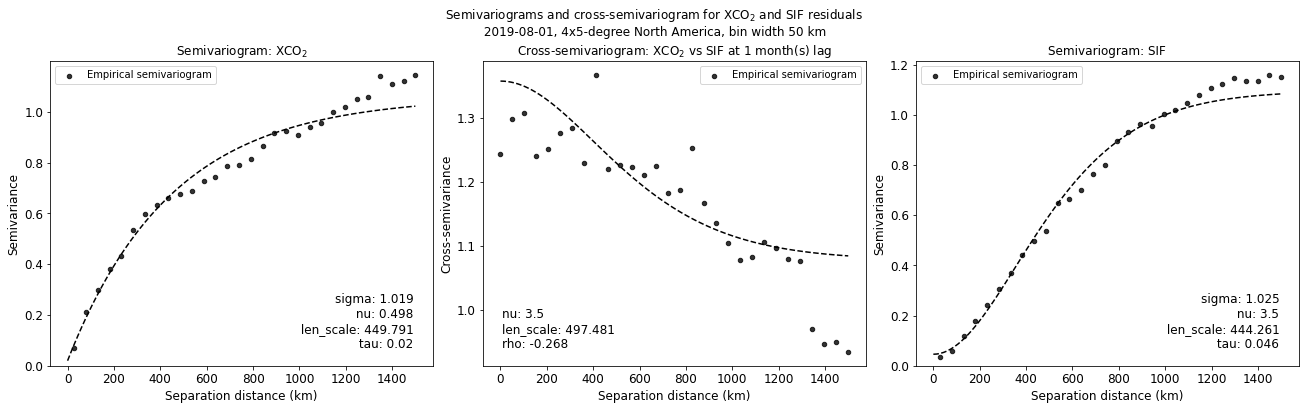

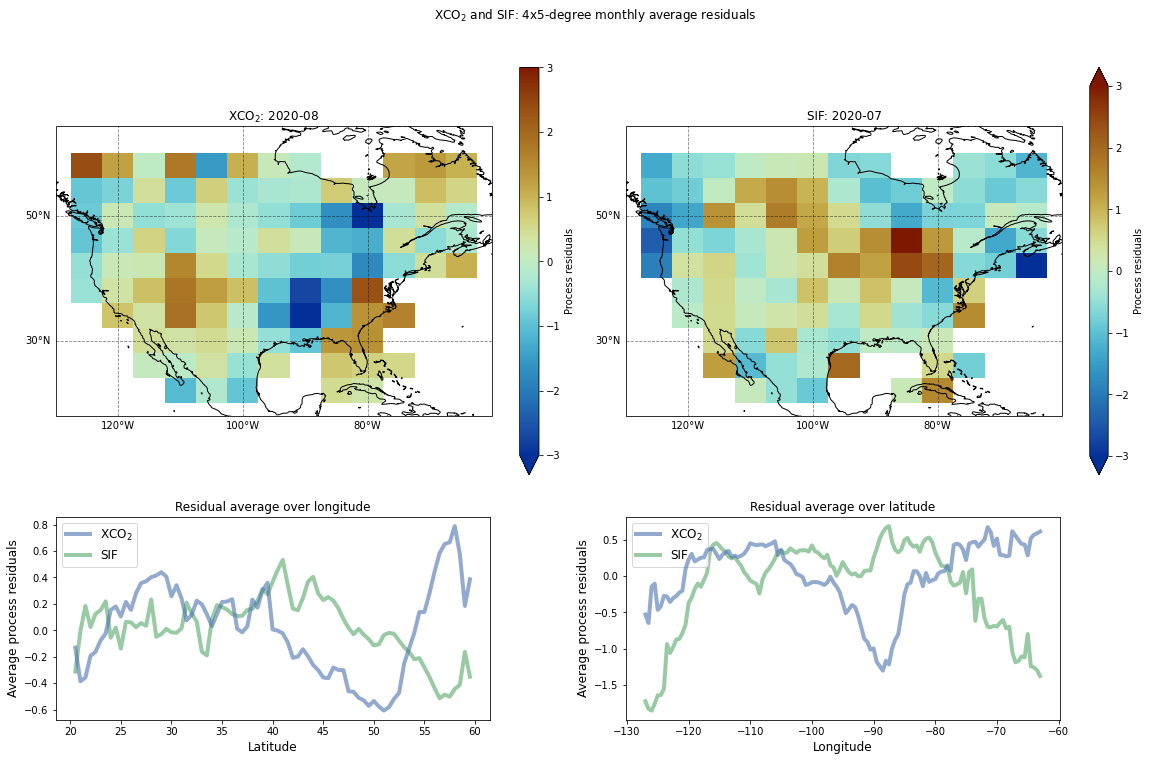

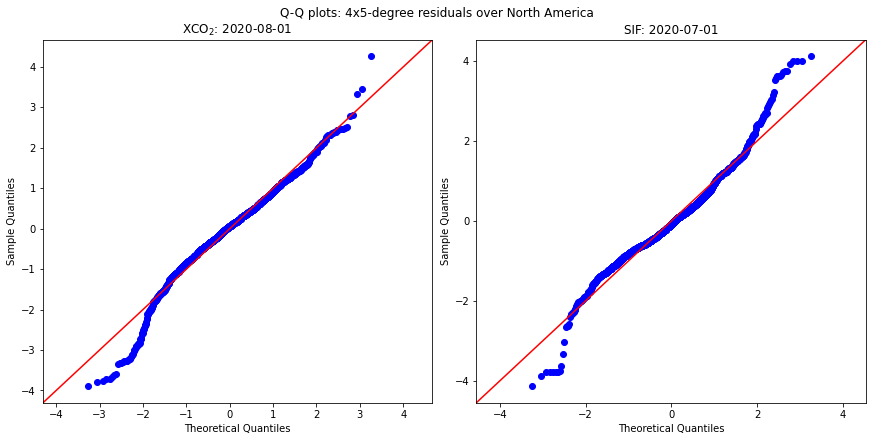

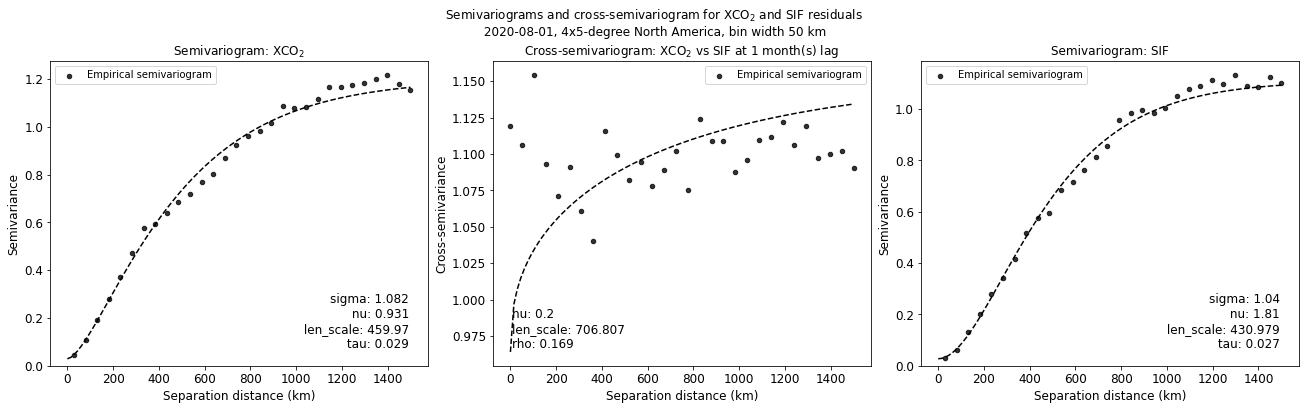

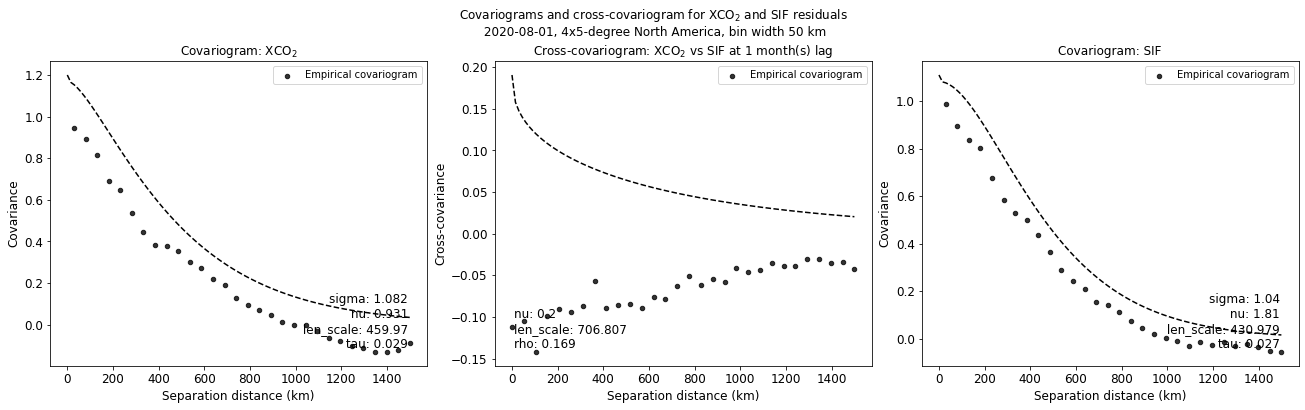

In [9]:
[variography_analysis(t) for t in timestamps];